<h1> Day 31 - Class </h1>

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv(r"D:\sanooj\datascience\data\bbc-news-train-data\BBC News Train.csv")
df_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
df_train['category_id'] = df_train['Category'].factorize()[0]
df_train.head()

,ArticleId,Text,Category,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


business - 0 | tech - 1 | politics - 2 | sport - 3 | entertainment - 4

In [16]:
#df_train[df_train['Category'] == 'business']['category_id'].value_counts()
#df_train[df_train['Category'] == 'tech']['category_id'].value_counts()
#df_train[df_train['Category'] == 'sport']['category_id'].value_counts()
#df_train[df_train['Category'] == 'politics']['category_id'].value_counts()
#df_train[df_train['Category'] == 'entertainment']['category_id'].value_counts() 

In [42]:
df_train['category_id'].value_counts()

3    346
0    336
2    274
4    273
1    261
Name: category_id, dtype: int64

In [43]:
df_train['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [44]:
df_train.groupby('Category').category_id.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: category_id, dtype: int64

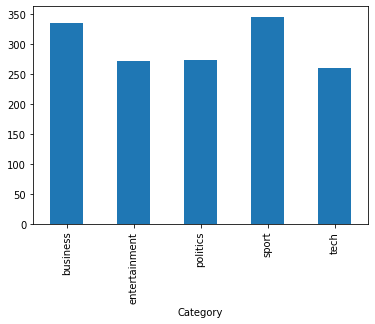

In [45]:
df_train.groupby('Category').category_id.count().plot.bar(ylim=0)

We will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. This statistic represents words’ importance in each document. We use a word's frequency as a proxy for its importance: if "football" is mentioned 25 times in a document, it might be more important than if it was only mentioned once. We also use the document frequency (the number of documents containing a given word) as a measure of how common the word is. This minimizes the effect of stop-words such as pronouns, or domain-specific language that does not add much information (for example, a word such as "news" that might be present in most documents).

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df_train.Text).toarray()
labels = df_train.category_id

In [18]:
category_to_id = {'business':0, 'tech':1, 'politics':2, 'sport':3, 'entertainment':4}
id_to_category = {0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [19]:
features

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03250994, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03842857, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

we can use the chi-squared test to find the terms are the most correlated with each of the categories:

In [37]:
# Use chi-square analysis to find corelation between features (importantce of words) and 
# labels(news category) 
from sklearn.feature_selection import chi2
N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
    # Do chi2 analyses of all items in this category
    features_chi2 = chi2(features, labels == category_id)
    # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    indices = np.argsort(features_chi2[0])
    # Converts indices to feature names ( in increasing order of chi-squared stat values)
    feature_names = np.array(tfidf.get_feature_names())[indices]
    # List of single word features ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    # List for two-word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          
    print("#'{}':".format(Category))
    # Print 3 unigrams with highest Chi squared stat
    print(" . Most correlated unigrams:\n    .{}".format('\n    .'.join(unigrams[-N:])))
    # Print 3 bigrams with highest Chi squared stat
    print(" . Most correlated bigrams:\n    .{}".format('\n    .'.join(bigrams[-N:]))) 

#'business':
 . Most correlated unigrams:
    .growth
    .bank
    .shares
 . Most correlated bigrams:
    .stock market
    .economic growth
    .analysts said
#'entertainment':
 . Most correlated unigrams:
    .singer
    .actor
    .film
 . Most correlated bigrams:
    .won best
    .los angeles
    .box office
#'politics':
 . Most correlated unigrams:
    .blair
    .election
    .labour
 . Most correlated bigrams:
    .prime minister
    .tony blair
    .mr blair
#'sport':
 . Most correlated unigrams:
    .match
    .coach
    .cup
 . Most correlated bigrams:
    .grand slam
    .champions league
    .australian open
#'tech':
 . Most correlated unigrams:
    .technology
    .software
    .users
 . Most correlated bigrams:
    .anti virus
    .mobile phones
    .mobile phone


In [38]:
##dimension reduction 
from sklearn.manifold import TSNE
# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
# Randomly select 30 % of samples
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False) 
# Array of all projected features of 30% of Randomly chosen samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])  

We can also use dimensionality reduction techniques, such t-SNE to project our high dimensional tf-idf features into a 2D plane, where they can be visualized.

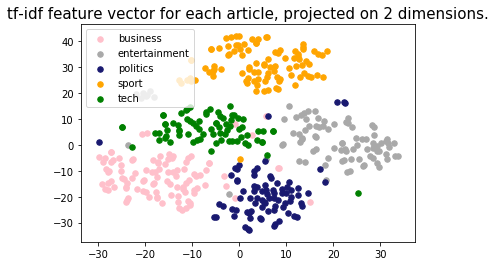

In [39]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

models = [
    
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=3)
]

In [41]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

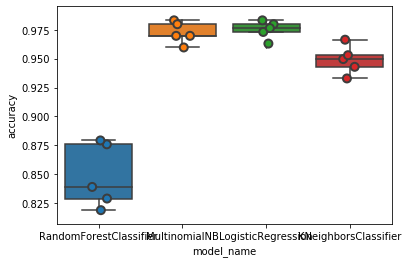

In [45]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

The results for the Random Forest model show a large variance, the sign of a model that is overfitting to its training data. Running cross-validation is vital, because results from a single train/test split might be misleading.We also notice that both Multinomial Naive Bayes and Logistic Regression perform extremely well, with Logistic Regression having a slight advantage with a median accuracy of around 97%

In [34]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.838926
1,RandomForestClassifier,1,0.818792
2,RandomForestClassifier,2,0.828859
3,RandomForestClassifier,3,0.875839
4,RandomForestClassifier,4,0.879195
5,MultinomialNB,0,0.969799
6,MultinomialNB,1,0.959732
7,MultinomialNB,2,0.983221
8,MultinomialNB,3,0.979866
9,MultinomialNB,4,0.969799


In [35]:
cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier      0.948993
LogisticRegression        0.975168
MultinomialNB             0.972483
RandomForestClassifier    0.848322
Name: accuracy, dtype: float64

In [36]:
from sklearn.model_selection import train_test_split

model = RandomForestClassifier()

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_train.index, test_size=0.33, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [37]:
category_id_df = df_train[['Category', 'category_id']].drop_duplicates().sort_values('category_id')

It’s not enough to have a model that performs well according to a given metric: we must also have a model that we can understand and whose results we can explain.We will start by training our model on part of the dataset, and then analyze the main sources of misclassification on the test set. One way to eliminate sources of error is to look at the confusion matrix, a matrix used to show the discrepancies between predicted and actual labels.

Text(0.5, 15.0, 'Predicted')

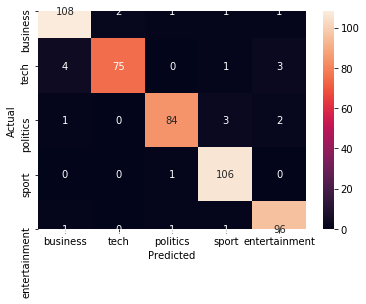

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Given the very high accuracy of our model, almost all the predictions end up on the diagonal (predicted label = actual label), right where we want them to be!

In [39]:
from IPython.display import display

for predicted in category_id_df.category_id:
   for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df_train.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['Text'])
      print('')

'tech' predicted as 'business' : 4 examples.


641    us woman sues over cartridges a us woman is su...
549    man auctions ad space on forehead a 20-year-ol...
686    gamers snap up new sony psp gamers have bought...
481    lasers help bridge network gaps an indian tele...
Name: Text, dtype: object


'business' predicted as 'tech' : 2 examples.


477     id theft surge hits us consumers almost a quar...
1384    brussels raps mobile call charges the european...
Name: Text, dtype: object


'politics' predicted as 'sport' : 3 examples.


5      howard  truanted to play snooker  conservative...
483    jamieson issues warning to bigots scotland s j...
569    labour chooses manchester the labour party wil...
Name: Text, dtype: object


'tech' predicted as 'entertainment' : 3 examples.


1091    ultimate game  award for doom 3 sci-fi shooter...
1115    ultimate game  award for doom 3 sci-fi shooter...
459     more movies head to sony s psp movies open wat...
Name: Text, dtype: object


'politics' predicted as 'entertainment' : 2 examples.


884    mp s shock at long lost daughter labour mp ste...
667    uk helps raped rwandan women britain is to giv...
Name: Text, dtype: object

Most of these examples are at the intersection of the ground truth category and the one predicted, which means even humans would struggle to classify them. This sort of noise is expected, and it is often unrealistic to aim for a model that achieves 100% accuracy.

Final model

In [ ]:
model2 = RandomForestClassifier()
model2.fit(features, labels)


text_submissions = pd.read_csv("../input/BBC News Test.csv")
submissions = pd.read_csv("../input/BBC News Sample Solution.csv")

test_features = tfidf.transform(text_submissions.Text.tolist())
prediction=model.predict(test_features)
id_to_category = {0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}
for i in range(len(prediction)):
    submissions.iloc[i,1] = id_to_category[prediction[i]]
    
# Convert submission dataframe to csv 
# you could use any filename. We choose submission here
submissions.to_csv('submission.csv', index=False)



Conclusion

Using off-the-shelf tools and simple models, we solved a complex task, that of document classification, which might have seemed daunting at first! To do so, we followed steps common to solving any task with machine learning:

            1. Load and pre-process data.
            2. Analyze patterns in the data, to gain insights.
            3. Train different models, and rigorously evaluate each of them.
            4. Interpret the trained model.

